In [1]:
# ===== БЛОК 1: ИМПОРТЫ И НАСТРОЙКИ =====
import os
import pandas as pd
import requests
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import json

# Настройки
pd.set_option('display.float_format', '{:.10f}'.format)
plt.style.use('default')

In [2]:
# ===== БЛОК 2: ЗАГРУЗКА ПЕРЕМЕННЫХ ОКРУЖЕНИЯ =====
load_dotenv()

API_URL = os.getenv('API_URL')
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')

# Проверка переменных
assert API_URL is not None, "API_URL не задан в .env"
assert DATE_BEGIN is not None, "DATE_BEGIN не задан в .env"
assert DATE_END is not None, "DATE_END не задан в .env"

print(f"Диапазон данных: {DATE_BEGIN} - {DATE_END}")

Диапазон данных: 2023-03-01 - 2023-09-01


In [3]:
# ===== БЛОК 3: ПОЛУЧЕНИЕ ДАННЫХ ИЗ API =====
def fetch_api_data():
    """Получение данных визитов и регистраций из API"""
    print("Загрузка данных из API...")
    
    # Запрос визитов
    visits_response = requests.get(
        f"{API_URL}/visits",
        params={'begin': DATE_BEGIN, 'end': DATE_END}
    )
    visits_response.raise_for_status()
    
    # Запрос регистраций
    regs_response = requests.get(
        f"{API_URL}/registrations", 
        params={'begin': DATE_BEGIN, 'end': DATE_END}
    )
    regs_response.raise_for_status()
    
    # Преобразование в DataFrame
    visits_df = pd.DataFrame(visits_response.json())
    regs_df = pd.DataFrame(regs_response.json())
    
    # Преобразуем datetime
    visits_df['datetime'] = pd.to_datetime(visits_df['datetime'])
    regs_df['datetime'] = pd.to_datetime(regs_df['datetime'])
    
    print(f"Загружено визитов: {len(visits_df)}")
    print(f"Загружено регистраций: {len(regs_df)}")
    
    return visits_df, regs_df

In [4]:
# ===== БЛОК 4: ПРЕДОБРАБОТКА ДАННЫХ =====
def preprocess_data(visits_df, regs_df):
    """Очистка и подготовка данных"""
    print("Предобработка данных...")
    
    # Фильтрация ботов
    visits_filtered = visits_df[visits_df['platform'] != 'bot'].copy()
    print(f"После фильтрации ботов: {len(visits_filtered)}")
    
    # Сначала создаем date_group
    visits_filtered['date_group'] = visits_filtered['datetime'].dt.strftime('%Y-%m-%d')
    
    # ДЕДУПЛИКАЦИЯ ПО VISIT_ID + DATE_GROUP (last paid click в рамках дня)
    visits_deduped = visits_filtered.sort_values('datetime').drop_duplicates(
        subset=['visit_id', 'date_group'], keep='last'
    ).copy()
    print(f"Визиты после дедупликации: {len(visits_deduped)}")
    
    regs_df['date_group'] = regs_df['datetime'].dt.strftime('%Y-%m-%d')
    
    return visits_deduped, regs_df

In [5]:
# ===== БЛОК 5: РАСЧЕТ КОНВЕРСИИ =====
def create_conversion_dataframe(visits_df, regs_df):
    """Создание DataFrame с расчетом конверсии"""
    print("Расчет конверсии...")
    
    # Группируем данные по дате и платформе
    visits_grouped = visits_df.groupby(['date_group', 'platform']).size().reset_index(name='visits')
    regs_grouped = regs_df.groupby(['date_group', 'platform']).size().reset_index(name='registrations')
    
    # Создаём полный календарь (все даты × все платформы)
    date_range = pd.date_range(start=DATE_BEGIN, end=DATE_END, freq='D')
    date_strings = date_range.strftime('%Y-%m-%d')
    platforms = ['android', 'ios', 'web']
    calendar = pd.MultiIndex.from_product([date_strings, platforms], 
                                        names=['date_group', 'platform']).to_frame(index=False)
    
    # Объединяем с данными
    conversion_df = calendar.merge(visits_grouped, on=['date_group', 'platform'], how='left') \
                           .merge(regs_grouped, on=['date_group', 'platform'], how='left')
    
    # Заполняем нулями и считаем конверсию
    conversion_df['visits'] = conversion_df['visits'].fillna(0).astype(int)
    conversion_df['registrations'] = conversion_df['registrations'].fillna(0).astype(int)
    conversion_df['conversion'] = conversion_df.apply(
        lambda row: round((row['registrations'] / row['visits']) * 100, 10) if row['visits'] > 0 else 0.0, 
        axis=1
    )
    
    # Сортируем
    conversion_df['platform'] = pd.Categorical(conversion_df['platform'], 
                                             categories=['android', 'ios', 'web'], ordered=True)
    conversion_df = conversion_df.sort_values(['date_group', 'platform']).reset_index(drop=True)
    
    return conversion_df

In [6]:
# ===== БЛОК 6: СОХРАНЕНИЕ JSON ФАЙЛОВ =====
def save_json_files(conversion_df, registrations_df):
    """Сохранение JSON файлов"""
    print("Сохранение JSON файлов...")
    
    # === conversion.json - ВЕСЬ ПЕРИОД (180 дней × 3 платформы) ===  
    print(f"Всего данных для conversion.json: {len(conversion_df)} строк")
    print(f"Диапазон дат: {conversion_df['date_group'].min()} - {conversion_df['date_group'].max()}")

    # Проверим регистрации за 22 марта
    regs_22_march = registrations_df[registrations_df['date_group'] == '2023-03-22']
    print(f"Регистрации за 22 марта: {len(regs_22_march)}")
    print("Регистрации по платформам за 22 марта:")
    print(regs_22_march['platform'].value_counts())
    
    df_for_json = conversion_df.copy()
    df_for_json['date_group'] = (pd.to_datetime(df_for_json['date_group']).astype('int64') // 10**6)
    
    # Проверяем данные за 22 марта (для отладки и проверки тестов)
    conversion_22_march = conversion_df[conversion_df['date_group'] == '2023-03-22']
    print("=== ДАННЫЕ ЗА 22 МАРТА 2023 (для проверки) ===")
    print(conversion_22_march[['platform', 'visits', 'registrations', 'conversion']])
    
    df_for_json.to_json('./conversion.json', orient='columns', double_precision=10)
    print(f"=== conversion.json сохранен ({len(df_for_json)} строк) ===")
    
    # === ads.json (остается без изменений) ===
    ads_df = pd.read_csv('./ads.csv')
    ads_df['date'] = pd.to_datetime(ads_df['date'])
    ads_df['date_group'] = ads_df['date'].dt.strftime('%Y-%m-%d')
    
    ads_grouped = ads_df.groupby('date_group').agg({'cost': 'sum', 'utm_campaign': 'first'}).reset_index()
    conversion_df_for_ads = conversion_df.copy()
    conversion_df_for_ads['date_group'] = pd.to_datetime(conversion_df_for_ads['date_group']).dt.strftime('%Y-%m-%d')
    metrics_total = conversion_df_for_ads.groupby('date_group')[['visits', 'registrations']].sum().reset_index()
    
    final_df = metrics_total.merge(ads_grouped, on='date_group', how='outer')
    final_df['cost'] = final_df['cost'].fillna(0).astype(int)
    final_df['utm_campaign'] = final_df['utm_campaign'].fillna('none')
    final_df = final_df.sort_values('date_group').reset_index(drop=True)
    final_df['date_group'] = (pd.to_datetime(final_df['date_group']).astype('int64') // 10**6)
    final_df.to_json('./ads.json', orient='columns')
    print("=== ads.json сохранен ===")

    # === ОТЛАДКА РЕГИСТРАЦИЙ ===
    print("=== ОТЛАДКА РЕГИСТРАЦИЙ ===")
    print(f"Всего регистраций в данных: {len(registrations_df)}")  # ← ИСПРАВИТЬ
    print(f"Уникальных user_id: {registrations_df['user_id'].nunique()}")  # ← ИСПРАВИТЬ
    print("Первые 10 регистраций:")
    print(registrations_df[['datetime', 'user_id', 'platform']].head(10))  # ← ИСПРАВИТЬ
    
    return final_df, ads_df

In [7]:
# ===== БЛОК 7: АГРЕГАЦИЯ ПО МЕСЯЦАМ =====
def create_monthly_data(visits_df, regs_df, ads_df):
    """Создание месячных агрегатов для графиков"""
    print("Агрегация данных по месяцам...")
    
    date_begin_dt = pd.to_datetime(DATE_BEGIN)
    date_end_dt = pd.to_datetime(DATE_END)
    month_range = pd.date_range(start=date_begin_dt.replace(day=1), 
                               end=date_end_dt.replace(day=1), 
                               freq='MS')
    
    # Визиты по месяцам
    visits_monthly = []
    for month_start in month_range:
        month_end = month_start + pd.offsets.MonthEnd(1)
        month_mask = (visits_df['datetime'] >= month_start) & (visits_df['datetime'] <= month_end)
        month_visits = visits_df[month_mask]
        
        for platform in ['android', 'ios', 'web']:
            visits_monthly.append({
                'date_group': month_start,
                'platform': platform,
                'visits': len(month_visits[month_visits['platform'] == platform])
            })
    
    visits_monthly_df = pd.DataFrame(visits_monthly)
    visits_pivot = visits_monthly_df.pivot_table(index='date_group', columns='platform', 
                                               values='visits', fill_value=0).reset_index()
    
    # Регистрации по месяцам
    regs_monthly = []
    for month_start in month_range:
        month_end = month_start + pd.offsets.MonthEnd(1)
        month_mask = (regs_df['datetime'] >= month_start) & (regs_df['datetime'] <= month_end)
        month_regs = regs_df[month_mask]
        
        for platform in ['android', 'ios', 'web']:
            regs_monthly.append({
                'date_group': month_start,
                'platform': platform,
                'registrations': len(month_regs[month_regs['platform'] == platform])
            })
    
    regs_monthly_df = pd.DataFrame(regs_monthly)
    regs_pivot = regs_monthly_df.pivot_table(index='date_group', columns='platform', 
                                           values='registrations', fill_value=0).reset_index()
    
    # Общие метрики по месяцам
    metrics_monthly = []
    for month_start in month_range:
        month_end = month_start + pd.offsets.MonthEnd(1)
        month_str = month_start.strftime('%Y-%m')
        
        month_visits_mask = (visits_df['datetime'] >= month_start) & (visits_df['datetime'] <= month_end)
        month_regs_mask = (regs_df['datetime'] >= month_start) & (regs_df['datetime'] <= month_end)
        month_ads_mask = (ads_df['date'] >= month_start) & (ads_df['date'] <= month_end)
        
        month_visits_total = len(visits_df[month_visits_mask])
        month_regs_total = len(regs_df[month_regs_mask])
        month_ads = ads_df[month_ads_mask]
        month_cost = month_ads['cost'].sum() if not month_ads.empty else 0
        month_campaign = month_ads['utm_campaign'].mode()[0] if not month_ads.empty and len(month_ads['utm_campaign'].mode()) > 0 else 'none'
        
        metrics_monthly.append({
            'date_group': month_start,
            'month_label': month_str,
            'visits': month_visits_total,
            'registrations': month_regs_total,
            'cost': month_cost,
            'utm_campaign': month_campaign
        })
    
    metrics_monthly_df = pd.DataFrame(metrics_monthly)
    
    # Добавляем метки и конверсию
    visits_pivot['month_label'] = visits_pivot['date_group'].dt.strftime('%Y-%m')
    regs_pivot['month_label'] = regs_pivot['date_group'].dt.strftime('%Y-%m')
    metrics_monthly_df['overall_conversion'] = (metrics_monthly_df['registrations'] / 
                                              metrics_monthly_df['visits'].replace(0, 1)) * 100
    
    print(f"Создано агрегатов для {len(metrics_monthly_df)} месяцев")
    
    return visits_pivot, regs_pivot, metrics_monthly_df

In [8]:
# ===== БЛОК 8: ПОДГОТОВКА К ПОСТРОЕНИЮ ГРАФИКОВ =====
def setup_plotting():
    """Настройки и подготовка к построению графиков"""
    print("Подготовка к построению графиков...")
    
    # Создаем папку для графиков
    os.makedirs('./charts', exist_ok=True)
    
    # Настройки стиля для всех графиков
    plt.rcParams['figure.figsize'] = (12, 6)
    
    # Цветовые схемы
    colors = {'android': '#4C72B0', 'ios': '#DD8452', 'web': '#55A868'}
    campaign_colors = {
        'advanced_algorithms_series': '#87CEFA',
        'virtual_reality_workshop': '#FFA07A',
        'none': 'none'
    }
    
    def setup_common_chart(title, ylabel, x_labels, rotation=45):
        """Общие настройки для графиков"""
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel('Month')
        plt.ylabel(ylabel)
        plt.xticks(range(len(x_labels)), x_labels, rotation=rotation, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
    
    return colors, campaign_colors, setup_common_chart

In [9]:
# ===== БЛОК 9: ГРАФИК 1 - TOTAL MONTHLY VISITS =====
def plot_total_visits(metrics_monthly, setup_common_chart):
    """График 1: Общие визиты по месяцам"""
    plt.figure()
    x_pos = range(len(metrics_monthly))
    bars = plt.bar(x_pos, metrics_monthly['visits'], color='skyblue', edgecolor='black', width=0.6)
    
    # Добавляем подписи значений
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(metrics_monthly['visits'])*0.01, 
                f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=9)
    
    setup_common_chart('Total Monthly Visits', 'Visits', metrics_monthly['month_label'])
    plt.savefig('./charts/total_visits.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ График 1: Total Monthly Visits - создан")


In [10]:
# ===== БЛОК 10: ГРАФИК 2 - VISITS BY PLATFORM =====
def plot_visits_by_platform(visits_pivot, colors, setup_common_chart):
    """График 2: Визиты по платформам"""
    plt.figure()
    x_pos = range(len(visits_pivot))
    bottom = np.zeros(len(visits_pivot))
    
    # Строим stacked bar chart
    for platform in ['android', 'ios', 'web']:
        values = visits_pivot[platform].values
        plt.bar(x_pos, values, bottom=bottom, color=colors[platform], 
                edgecolor='black', label=platform, width=0.6)
        bottom += values
    
    # Добавляем подписи общих значений
    for i, total in enumerate(bottom):
        plt.text(i, total + max(bottom)*0.01, f'{int(total):,}', 
                ha='center', va='bottom', fontsize=9)
    
    setup_common_chart('Monthly Visits by Platform', 'Visits', visits_pivot['month_label'])
    plt.legend(title='Platform')
    plt.savefig('./charts/visits_by_platform.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ График 2: Monthly Visits by Platform - создан")

In [11]:
# ===== БЛОК 11: ГРАФИК 3 - TOTAL REGISTRATIONS =====
def plot_total_registrations(metrics_monthly, setup_common_chart):
    """График 3: Общие регистрации по месяцам"""
    plt.figure()
    x_pos = range(len(metrics_monthly))
    bars = plt.bar(x_pos, metrics_monthly['registrations'], color='lightgreen', edgecolor='black', width=0.6)
    
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(metrics_monthly['registrations'])*0.01, 
                f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=9)
    
    setup_common_chart('Total Monthly Registrations', 'Registrations', metrics_monthly['month_label'])
    plt.savefig('./charts/total_registrations.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ График 3: Total Monthly Registrations - создан")

In [12]:
# ===== БЛОК 12: ГРАФИК 4 - REGISTRATIONS BY PLATFORM =====
def plot_registrations_by_platform(regs_pivot, colors, setup_common_chart):
    """График 4: Регистрации по платформам (линейный)"""
    plt.figure()
    x_pos = range(len(regs_pivot))
    
    for platform in ['android', 'ios', 'web']:
        plt.plot(x_pos, regs_pivot[platform], marker='o', 
                label=platform, linewidth=2.5, markersize=6)
    
    setup_common_chart('Monthly Registrations by Platform', 'Registrations', regs_pivot['month_label'])
    plt.legend(title='Platform')
    plt.grid(True, alpha=0.3)
    plt.savefig('./charts/registrations_by_platform.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ График 4: Monthly Registrations by Platform - создан")

In [13]:
# ===== БЛОК 13: ГРАФИК 5 - CONVERSION BY PLATFORM =====
def plot_conversion_by_platform(visits_pivot, regs_pivot, colors, setup_common_chart):
    """График 5: Конверсия по платформам"""
    plt.figure()
    x_pos = range(len(visits_pivot))
    
    for platform in ['android', 'ios', 'web']:
        visits = visits_pivot[platform].replace(0, 1)
        regs = regs_pivot[platform]
        conversion = (regs / visits * 100).fillna(0)
        plt.plot(x_pos, conversion, marker='o', 
                label=platform, linewidth=2.5, markersize=6)
    
    setup_common_chart('Conversion by Platform', 'Conversion (%)', visits_pivot['month_label'])
    plt.legend(title='Platform')
    plt.grid(True, alpha=0.3)
    plt.savefig('./charts/conversion_by_platform.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ График 5: Conversion by Platform - создан")

In [14]:
# ===== БЛОК 14: ГРАФИК 6 - OVERALL CONVERSION =====
def plot_overall_conversion(metrics_monthly, setup_common_chart):
    """График 6: Общая конверсия"""
    plt.figure()
    x_pos = range(len(metrics_monthly))
    
    plt.plot(x_pos, metrics_monthly['overall_conversion'],
            marker='o', linestyle='-', linewidth=3, color='blue', 
            markersize=8, label='Overall Conversion')
    
    # Добавляем подписи значений
    for i, row in metrics_monthly.iterrows():
        if not pd.isna(row['overall_conversion']) and row['overall_conversion'] > 0:
            plt.text(i, row['overall_conversion'] + 0.5,
                    f"{row['overall_conversion']:.1f}%",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    setup_common_chart('Overall Conversion', 'Conversion (%)', metrics_monthly['month_label'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('./charts/overall_conversion.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ График 6: Overall Conversion - создан")

In [15]:
# ===== БЛОК 15: ГРАФИК 7 - AD SPEND BY MONTH =====
def plot_ad_spend(metrics_monthly, setup_common_chart):
    """График 7: Затраты на рекламу по месяцам"""
    plt.figure()
    x_pos = range(len(metrics_monthly))
    
    plt.plot(x_pos, metrics_monthly['cost'],
            marker='s', linewidth=3, color='purple', markersize=8)
    
    # Добавляем подписи затрат
    for i, row in metrics_monthly.iterrows():
        plt.text(i, row['cost'] + max(metrics_monthly['cost'])*0.01, 
                f"{int(row['cost']):,} RUB",
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    setup_common_chart('Total Ad Spend by Month', 'Cost (RUB)', metrics_monthly['month_label'])
    plt.grid(True, alpha=0.3)
    plt.savefig('./charts/ad_campaign_costs.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ График 7: Total Ad Spend by Month - создан")

In [16]:
# ===== БЛОК 16: ГРАФИК 8 - VISITS DURING MARKETING =====
def plot_visits_during_marketing(final_df, campaign_colors):
    """График 8: Визиты в периоды маркетинговых активностей"""
    plt.figure()
    plt.plot(final_df['date_group'], final_df['visits'], marker='o', linestyle='-', linewidth=2, color='black', label='Visits')
    
    avg_visits = final_df['visits'].mean()
    plt.axhline(avg_visits, color='gray', linestyle='--', linewidth=1, label=f'Average ({int(avg_visits)})')
    
    # Добавляем цветные зоны кампаний
    current_campaign = None
    start_date = None
    
    for i, row in final_df.iterrows():
        campaign = row['utm_campaign']
        if campaign != current_campaign:
            if current_campaign and start_date:
                plt.axvspan(start_date, row['date_group'], color=campaign_colors.get(current_campaign, 'none'), alpha=0.3)
            current_campaign = campaign
            start_date = row['date_group']
    
    if current_campaign and start_date:
        plt.axvspan(start_date, final_df['date_group'].iloc[-1], color=campaign_colors.get(current_campaign, 'none'), alpha=0.3)
    
    plt.title('Visits during marketing active days', fontsize=12)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Unique Visits', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('./charts/visits_during_marketing.png', dpi=300)
    plt.show()
    print("✓ График 8: Visits during marketing active days - создан")

In [17]:
# ===== БЛОК 17: ГРАФИК 9 - REGISTRATIONS DURING MARKETING =====
def plot_registrations_during_marketing(final_df, campaign_colors):
    """График 9: Регистрации в периоды маркетинговых активностей"""
    plt.figure()
    plt.plot(final_df['date_group'], final_df['registrations'], marker='o', linestyle='-', linewidth=2, color='green', label='Registrations')
    
    avg_regs = final_df['registrations'].mean()
    plt.axhline(avg_regs, color='gray', linestyle='--', linewidth=1, label=f'Average ({int(avg_regs)})')
    
    # Добавляем цветные зоны кампаний
    current_campaign = None
    start_date = None
    
    for i, row in final_df.iterrows():
        campaign = row['utm_campaign']
        if campaign != current_campaign:
            if current_campaign and start_date:
                plt.axvspan(start_date, row['date_group'], color=campaign_colors.get(current_campaign, 'none'), alpha=0.3)
            current_campaign = campaign
            start_date = row['date_group']
    
    if current_campaign and start_date:
        plt.axvspan(start_date, final_df['date_group'].iloc[-1], color=campaign_colors.get(current_campaign, 'none'), alpha=0.3)
    
    plt.title('Registrations during marketing active days', fontsize=12)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Unique Users', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('./charts/registrations_during_marketing.png', dpi=300)
    plt.show()
    print("✓ График 9: Registrations during marketing active days - создан")

In [18]:
# ===== БЛОК 18: ОСНОВНАЯ ФУНКЦИЯ ПОСТРОЕНИЯ ГРАФИКОВ =====
def create_all_plots(visits_pivot, regs_pivot, metrics_monthly, final_df):
    """Создание всех 9 графиков"""
    print("=== НАЧАЛО ПОСТРОЕНИЯ ГРАФИКОВ ===")
    
    # Подготовка
    colors, campaign_colors, setup_common_chart = setup_plotting()
    
    # Построение всех графиков
    plot_total_visits(metrics_monthly, setup_common_chart)
    plot_visits_by_platform(visits_pivot, colors, setup_common_chart)
    plot_total_registrations(metrics_monthly, setup_common_chart)
    plot_registrations_by_platform(regs_pivot, colors, setup_common_chart)
    plot_conversion_by_platform(visits_pivot, regs_pivot, colors, setup_common_chart)
    plot_overall_conversion(metrics_monthly, setup_common_chart)
    plot_ad_spend(metrics_monthly, setup_common_chart)
    plot_visits_during_marketing(final_df, campaign_colors)
    plot_registrations_during_marketing(final_df, campaign_colors)
    
    print("=== ВСЕ 9 ГРАФИКОВ УСПЕШНО СОЗДАНЫ ===")

=== ЗАПУСК АНАЛИТИКИ ДАННЫХ ===
Загрузка данных из API...
Загружено визитов: 263459
Загружено регистраций: 21836
Предобработка данных...
После фильтрации ботов: 256077
Визиты после дедупликации: 250432
Расчет конверсии...
Сохранение JSON файлов...
Всего данных для conversion.json: 555 строк
Диапазон дат: 2023-03-01 - 2023-09-01
Регистрации за 22 марта: 130
Регистрации по платформам за 22 марта:
platform
android    68
ios        32
web        30
Name: count, dtype: int64
=== ДАННЫЕ ЗА 22 МАРТА 2023 (для проверки) ===
   platform  visits  registrations    conversion
63  android      77             68 88.3116883117
64      ios      37             32 86.4864864865
65      web     799             30  3.7546933667
=== conversion.json сохранен (555 строк) ===
=== ads.json сохранен ===
=== ОТЛАДКА РЕГИСТРАЦИЙ ===
Всего регистраций в данных: 21836
Уникальных user_id: 21836
Первые 10 регистраций:
             datetime                               user_id platform
0 2023-03-01 07:40:13  2e0f6bb8

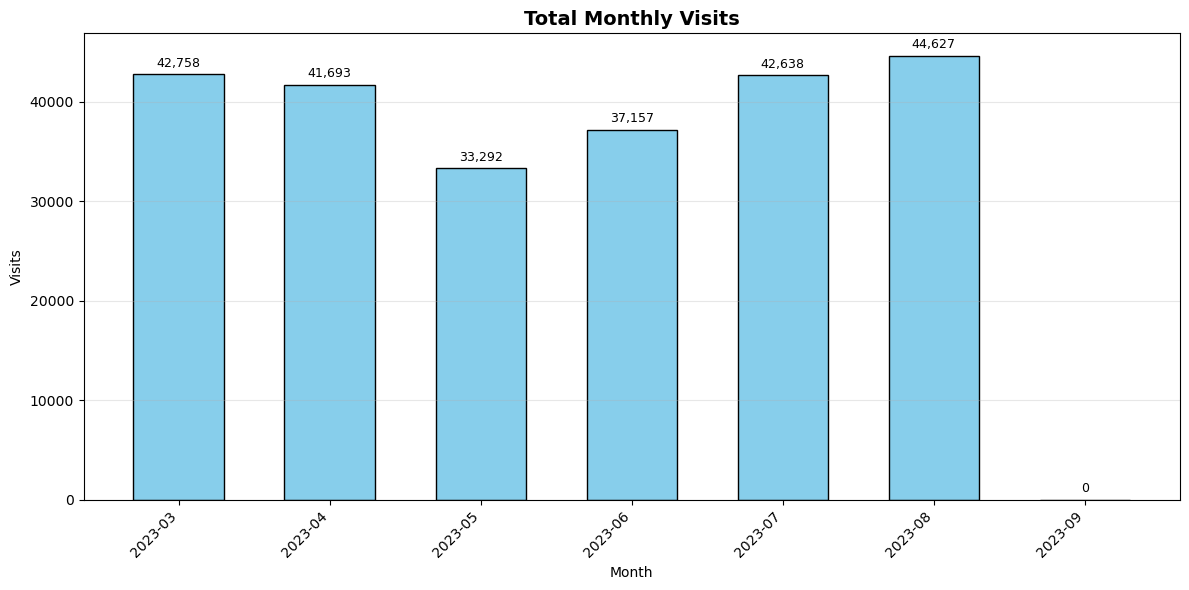

✓ График 1: Total Monthly Visits - создан


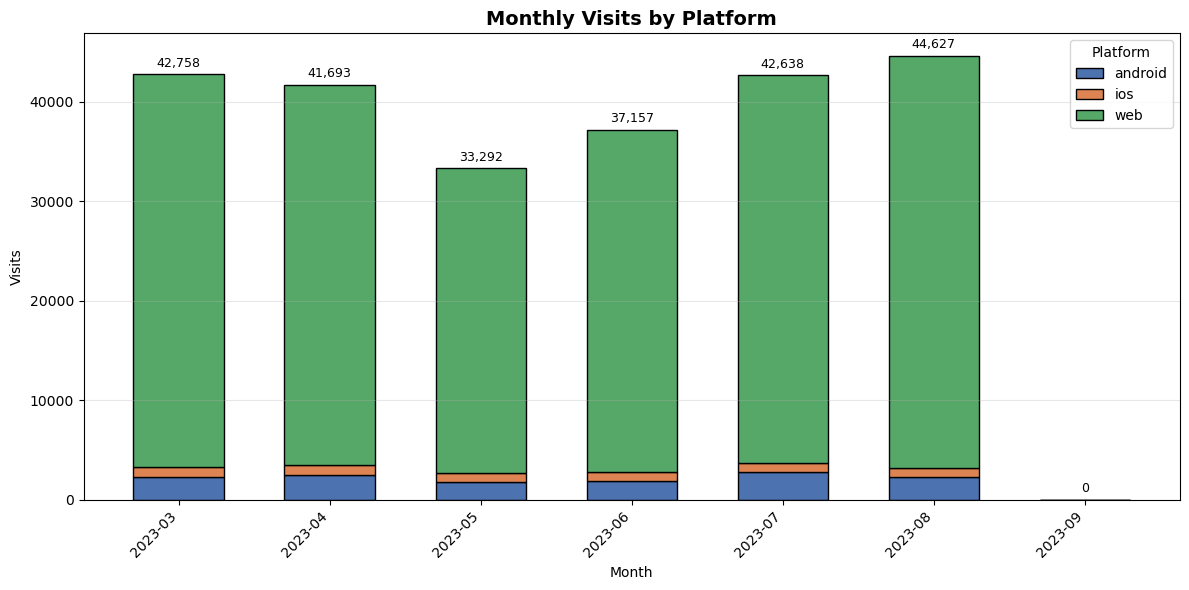

✓ График 2: Monthly Visits by Platform - создан


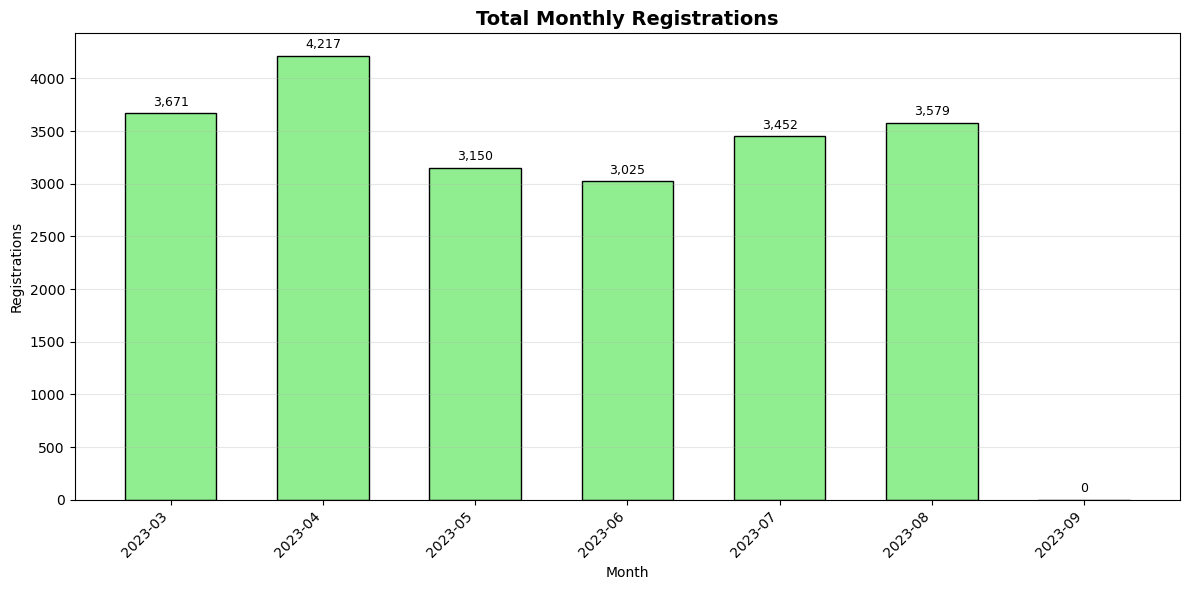

✓ График 3: Total Monthly Registrations - создан


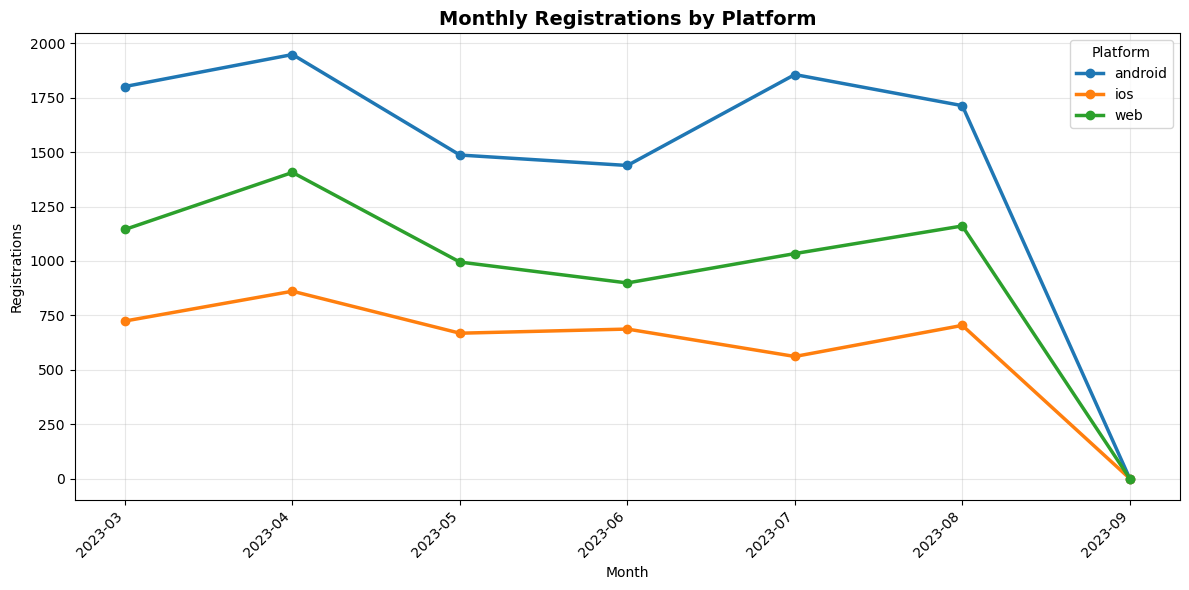

✓ График 4: Monthly Registrations by Platform - создан


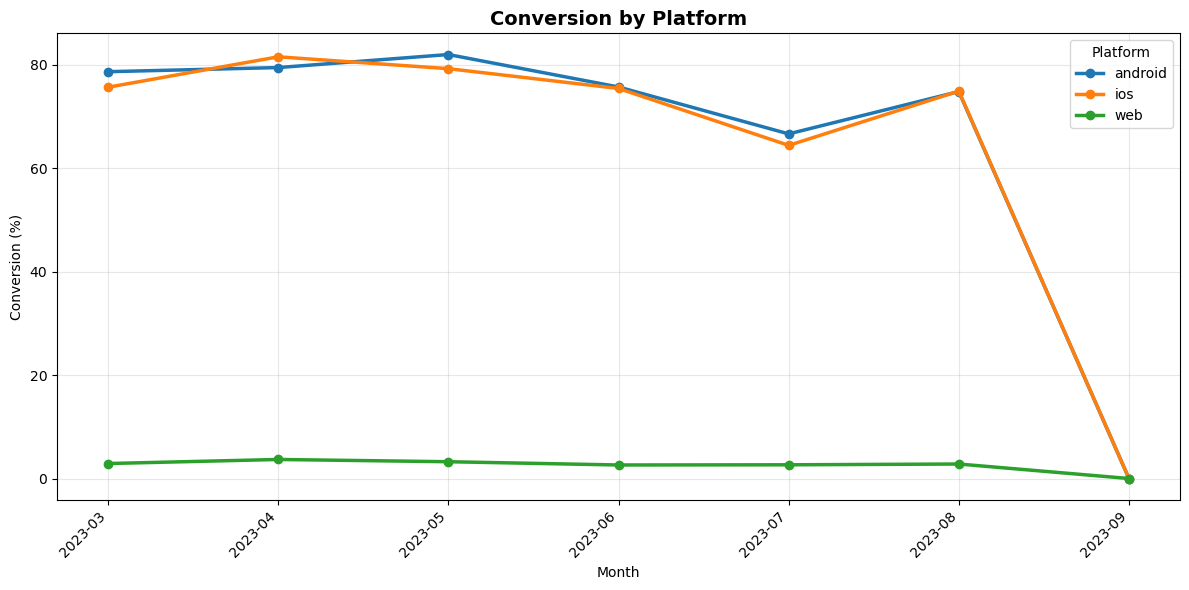

✓ График 5: Conversion by Platform - создан


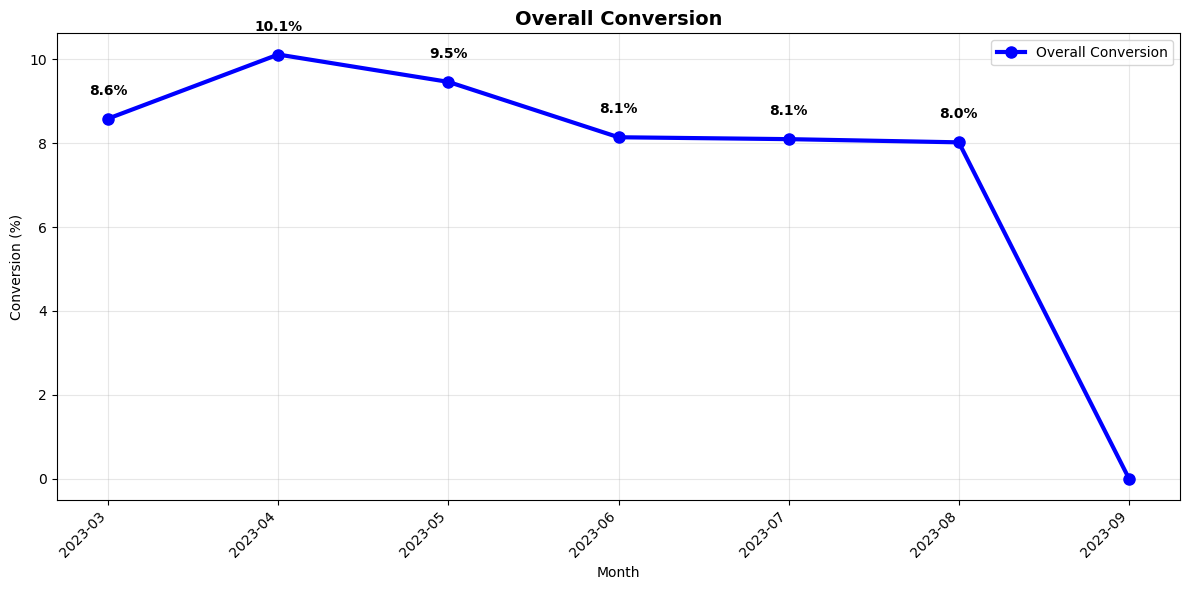

✓ График 6: Overall Conversion - создан


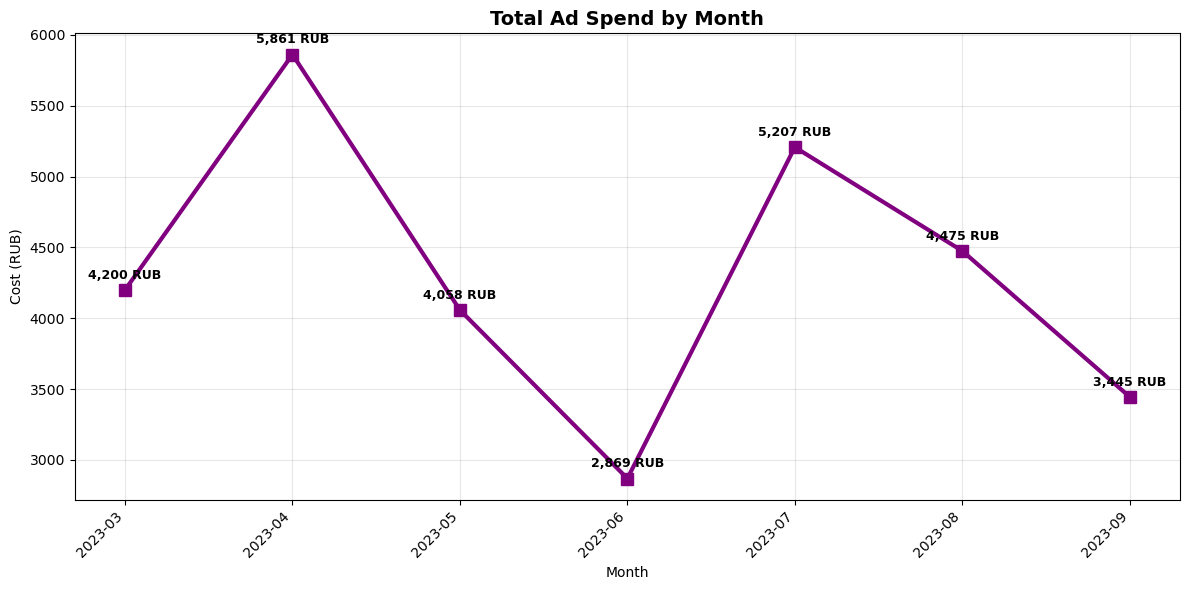

✓ График 7: Total Ad Spend by Month - создан


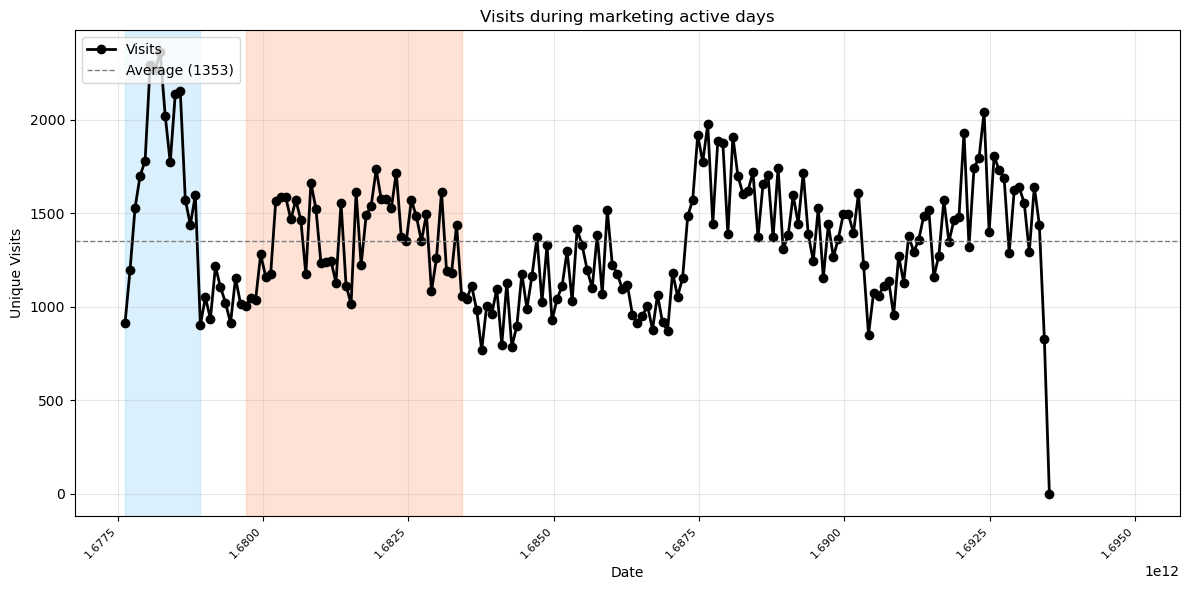

✓ График 8: Visits during marketing active days - создан


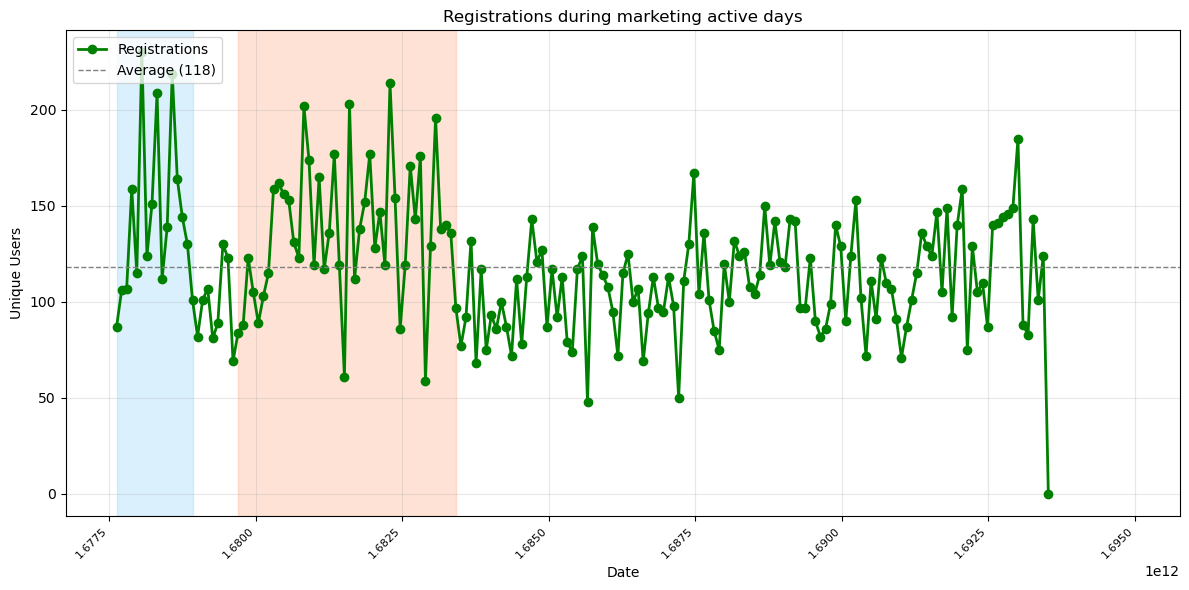

✓ График 9: Registrations during marketing active days - создан
=== ВСЕ 9 ГРАФИКОВ УСПЕШНО СОЗДАНЫ ===
=== АНАЛИТИКА УСПЕШНО ЗАВЕРШЕНА ===
Создано: 9 графиков, 2 JSON файла
Диапазон: 2023-03-01 - 2023-09-01


In [19]:
# ===== БЛОК 19: ЗАПУСК ВСЕГО ПРОЦЕССА =====
print("=== ЗАПУСК АНАЛИТИКИ ДАННЫХ ===")

# 1. Получение данных из API
visits_df, regs_df = fetch_api_data()

# 2. Предобработка данных
visits_clean, regs_clean = preprocess_data(visits_df, regs_df)

# 3. Расчет конверсии
conversion_df = create_conversion_dataframe(visits_clean, regs_clean)

# 4. Сохранение JSON файлов
final_df, ads_df = save_json_files(conversion_df, regs_clean)

# 5. Агрегация по месяцам
visits_pivot, regs_pivot, metrics_monthly = create_monthly_data(visits_clean, regs_clean, ads_df)

# 6. Создание графиков
create_all_plots(visits_pivot, regs_pivot, metrics_monthly, final_df)

print("=== АНАЛИТИКА УСПЕШНО ЗАВЕРШЕНА ===")
print(f"Создано: 9 графиков, 2 JSON файла")
print(f"Диапазон: {DATE_BEGIN} - {DATE_END}")

In [20]:
# ===== БЛОК 20: АНАЛИЗ ДАННЫХ ЗА 22 МАРТА =====
print("=== ДЕТАЛЬНЫЙ АНАЛИЗ ДАННЫХ ЗА 22 МАРТА 2023 ===")

# 1. Визиты за 22 марта 2023
visits_22 = visits_df[visits_df['datetime'].dt.date == pd.to_datetime('2023-03-22').date()]
print(f"Всего визитов за 22 марта: {len(visits_22)}")
print("Визиты по платформам:")
print(visits_22['platform'].value_counts())

# Проверим дубликаты visit_id за 22 марта
duplicates_22 = visits_22[visits_22.duplicated('visit_id', keep=False)]
print(f"Дублированных visit_id за 22 марта: {len(duplicates_22)}")
if len(duplicates_22) > 0:
    print("Примеры дубликатов:")
    print(duplicates_22[['visit_id', 'datetime', 'platform']].head(10))

# 2. Регистрации за 22 марта
regs_22 = regs_df[regs_df['datetime'].dt.date == pd.to_datetime('2023-03-22').date()]
print(f"Всего регистраций за 22 марта: {len(regs_22)}")
print("Регистрации по платформам:")
print(regs_22['platform'].value_counts())

=== ДЕТАЛЬНЫЙ АНАЛИЗ ДАННЫХ ЗА 22 МАРТА 2023 ===
Всего визитов за 22 марта: 930
Визиты по платформам:
platform
web        816
android     77
ios         37
Name: count, dtype: int64
Дублированных visit_id за 22 марта: 34
Примеры дубликатов:
                                   visit_id            datetime platform
34936  a21d52fd-be01-4eae-908e-fbd44800264c 2023-03-22 07:57:33      web
34937  a21d52fd-be01-4eae-908e-fbd44800264c 2023-03-22 14:01:42      web
36003  9ec61d96-1f17-4e5f-bb06-9c655ab7669c 2023-03-22 20:19:46      web
36004  9ec61d96-1f17-4e5f-bb06-9c655ab7669c 2023-03-22 17:17:33      web
36420  18c10e40-a8fe-4b23-b26b-57cf5134fe5e 2023-03-22 12:10:39      web
36421  18c10e40-a8fe-4b23-b26b-57cf5134fe5e 2023-03-22 18:31:19      web
36441  6d10a4d4-be4c-42de-ad39-110da252f28d 2023-03-22 03:09:50      web
36442  6d10a4d4-be4c-42de-ad39-110da252f28d 2023-03-22 00:21:41      web
36501  54a7d5ea-b544-4e4d-88e2-f3aa7cee3ad8 2023-03-22 08:33:40      web
36502  54a7d5ea-b544-4e4d-88e